Dataset loaded successfully!
Train dataset shape: (113754, 24)
Test dataset shape: (28439, 23)

Target variable distribution:
RainTomorrow
0    88252
1    25502
Name: count, dtype: int64
RainTomorrow
0    0.775814
1    0.224186
Name: proportion, dtype: float64

Missing values in training data:
Sunshine         54344
Evaporation      48695
Cloud3pm         45669
Cloud9am         42877
Pressure9am      11287
Pressure3pm      11262
WindDir9am        8055
WindGustDir       7485
WindGustSpeed     7440
WindDir3pm        3066
Humidity3pm       2897
Temp3pm           2203
WindSpeed3pm      2130
Humidity9am       1418
RainToday         1131
Rainfall          1131
WindSpeed9am      1082
Temp9am            735
MinTemp            513
MaxTemp            258
dtype: int64

Basic statistics:
                  id        MinTemp        MaxTemp       Rainfall  \
count  113754.000000  113241.000000  113496.000000  112623.000000   
mean    56876.500000      12.172898      23.218870       2.360774   
std   

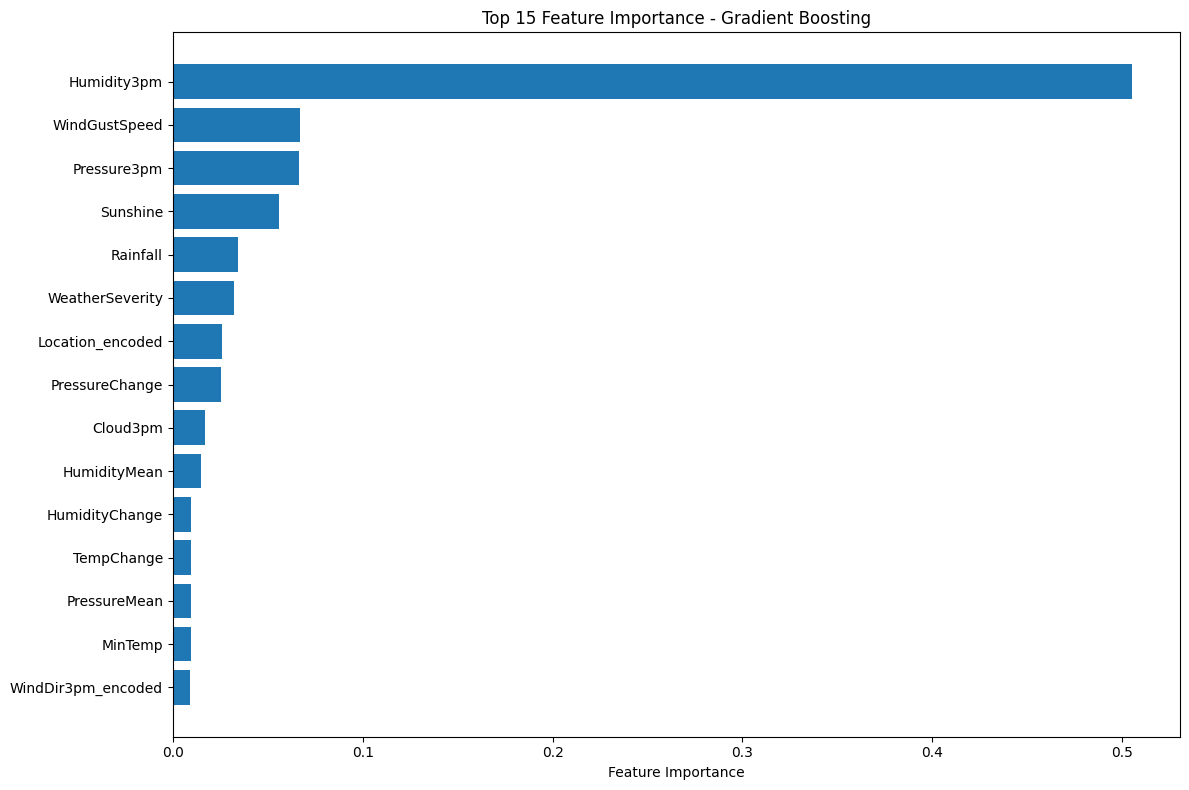


COMPETITION SUMMARY
 Best Model: Gradient Boosting
 Validation F1 Score: 0.6200
 Total Features Used: 46
 Training Samples: 113754
 Test Predictions: 28439


In [1]:
# Weather Prediction Competition - Complete Kaggle Notebook Solution
# Predict whether it will rain tomorrow based on today's weather observations

# =====================================
# 1. IMPORT LIBRARIES AND LOAD DATA
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load the competition data (automatically available in Kaggle environment)
train_df = pd.read_csv('/kaggle/input/idealize-2025-practice-competition/train.csv')
test_df = pd.read_csv('/kaggle/input/idealize-2025-practice-competition/test.csv')
sample_submission = pd.read_csv('/kaggle/input/idealize-2025-practice-competition/sample_submission.csv')

print("Dataset loaded successfully!")
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("\nTarget variable distribution:")
print(train_df['RainTomorrow'].value_counts())
print(train_df['RainTomorrow'].value_counts(normalize=True))

# =====================================
# 2. EXPLORATORY DATA ANALYSIS
# =====================================

# Check missing values
print("\nMissing values in training data:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0].sort_values(ascending=False))

# Basic statistics
print("\nBasic statistics:")
print(train_df.describe())

# Correlation with target
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
correlations = train_df[numerical_cols].corr()['RainTomorrow'].sort_values(ascending=False)
print("\nTop correlations with RainTomorrow:")
print(correlations.head(10))

# =====================================
# 3. COMPREHENSIVE DATA PREPROCESSING
# =====================================

def advanced_preprocessing(df, is_train=True):
    """
    Advanced preprocessing with feature engineering
    """
    df = df.copy()
    
    # ===== DATE FEATURES =====
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfYear'] = df['Date'].dt.dayofyear
        df['WeekOfYear'] = df['Date'].dt.isocalendar().week
        df['Quarter'] = df['Date'].dt.quarter
        
        # Seasonal features
        df['Season'] = df['Month'].map({
            12: 'Summer', 1: 'Summer', 2: 'Summer',
            3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
            6: 'Winter', 7: 'Winter', 8: 'Winter',
            9: 'Spring', 10: 'Spring', 11: 'Spring'
        })
    
    # ===== TEMPERATURE FEATURES =====
    # Temperature range and averages
    if 'MaxTemp' in df.columns and 'MinTemp' in df.columns:
        df['TempRange'] = df['MaxTemp'] - df['MinTemp']
        df['TempMean'] = (df['MaxTemp'] + df['MinTemp']) / 2
    
    # Temperature change throughout the day
    if 'Temp3pm' in df.columns and 'Temp9am' in df.columns:
        df['TempChange'] = df['Temp3pm'] - df['Temp9am']
        df['TempMean_Day'] = (df['Temp9am'] + df['Temp3pm']) / 2
    
    # ===== PRESSURE FEATURES =====
    if 'Pressure3pm' in df.columns and 'Pressure9am' in df.columns:
        df['PressureChange'] = df['Pressure3pm'] - df['Pressure9am']
        df['PressureMean'] = (df['Pressure9am'] + df['Pressure3pm']) / 2
        # Pressure trend indicator
        df['PressureTrend'] = np.where(df['PressureChange'] > 0, 'Rising', 
                                     np.where(df['PressureChange'] < 0, 'Falling', 'Stable'))
    
    # ===== HUMIDITY FEATURES =====
    if 'Humidity3pm' in df.columns and 'Humidity9am' in df.columns:
        df['HumidityChange'] = df['Humidity3pm'] - df['Humidity9am']
        df['HumidityMean'] = (df['Humidity9am'] + df['Humidity3pm']) / 2
        # High humidity indicator
        df['HighHumidity'] = ((df['Humidity9am'] > 80) | (df['Humidity3pm'] > 80)).astype(int)
    
    # ===== WIND FEATURES =====
    if 'WindSpeed3pm' in df.columns and 'WindSpeed9am' in df.columns:
        df['WindSpeedChange'] = df['WindSpeed3pm'] - df['WindSpeed9am']
        df['WindSpeedMean'] = (df['WindSpeed9am'] + df['WindSpeed3pm']) / 2
        df['WindSpeedMax'] = np.maximum(df['WindSpeed9am'], df['WindSpeed3pm'])
    
    # ===== CLOUD FEATURES =====
    if 'Cloud3pm' in df.columns and 'Cloud9am' in df.columns:
        df['CloudChange'] = df['Cloud3pm'] - df['Cloud9am']
        df['CloudMean'] = (df['Cloud9am'] + df['Cloud3pm']) / 2
        df['CloudMax'] = np.maximum(df['Cloud9am'], df['Cloud3pm'])
        # Heavy cloud cover indicator
        df['HeavyCloud'] = (df['CloudMax'] >= 7).astype(int)
    
    # ===== WEATHER CONDITION FEATURES =====
    # Rain today as binary
    if 'RainToday' in df.columns:
        df['RainToday_Binary'] = df['RainToday'].map({'Yes': 1, 'No': 0})
        df['RainToday_Binary'] = df['RainToday_Binary'].fillna(0)
    
    # Combined weather severity score
    if all(col in df.columns for col in ['Rainfall', 'WindGustSpeed', 'Humidity3pm']):
        df['WeatherSeverity'] = (
            (df['Rainfall'] > 1).astype(int) * 2 +
            (df['WindGustSpeed'] > 40).astype(int) * 1 +
            (df['Humidity3pm'] > 80).astype(int) * 1
        )
    
    # ===== ENCODE CATEGORICAL VARIABLES =====
    categorical_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Season', 'PressureTrend']
    
    for col in categorical_columns:
        if col in df.columns:
            # Fill missing values
            df[col] = df[col].fillna('Unknown')
            
            # Label encoding
            le = LabelEncoder()
            df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    
    # ===== HANDLE MISSING VALUES =====
    # Fill numerical columns with median
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        if col != 'RainTomorrow':  # Don't fill target variable
            df[col] = df[col].fillna(df[col].median())
    
    return df

# Apply preprocessing
print("Applying advanced preprocessing...")
train_processed = advanced_preprocessing(train_df, is_train=True)
test_processed = advanced_preprocessing(test_df, is_train=False)
print("Preprocessing completed!")

# =====================================
# 4. FEATURE SELECTION
# =====================================

# Define comprehensive feature set
feature_columns = [
    # Original numerical features
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
    'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
    
    # Engineered temperature features
    'TempRange', 'TempMean', 'TempChange', 'TempMean_Day',
    
    # Engineered pressure features
    'PressureChange', 'PressureMean',
    
    # Engineered humidity features
    'HumidityChange', 'HumidityMean', 'HighHumidity',
    
    # Engineered wind features
    'WindSpeedChange', 'WindSpeedMean', 'WindSpeedMax',
    
    # Engineered cloud features
    'CloudChange', 'CloudMean', 'CloudMax', 'HeavyCloud',
    
    # Date features
    'Year', 'Month', 'Day', 'DayOfYear', 'WeekOfYear', 'Quarter',
    
    # Encoded categorical features
    'Location_encoded', 'WindGustDir_encoded', 'WindDir9am_encoded', 
    'WindDir3pm_encoded', 'Season_encoded', 'PressureTrend_encoded',
    
    # Weather condition features
    'RainToday_Binary', 'WeatherSeverity'
]

# Filter features that exist in both datasets
available_features = [col for col in feature_columns 
                     if col in train_processed.columns and col in test_processed.columns]

print(f"Using {len(available_features)} features for modeling")

# Prepare data for modeling
X_train = train_processed[available_features]
y_train = train_processed['RainTomorrow']
X_test = test_processed[available_features]

# =====================================
# 5. MODEL TRAINING AND EVALUATION
# =====================================

# Split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42, 
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        C=1.0
    )
}

# Train and evaluate models
results = {}
best_model = None
best_f1 = 0
best_model_name = ''

print("\n" + "="*60)
print("TRAINING AND EVALUATING MODELS")
print("="*60)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name == 'Logistic Regression':
        # Scale features for logistic regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_split)
        X_val_scaled = scaler.transform(X_val_split)
        
        model.fit(X_train_scaled, y_train_split)
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        model.fit(X_train_split, y_train_split)
        y_pred = model.predict(X_val_split)
        y_pred_proba = model.predict_proba(X_val_split)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_val_split, y_pred)
    
    results[name] = {
        'model': model,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:")
    print(classification_report(y_val_split, y_pred))
    
    # Update best model
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_model_name = name
        if name == 'Logistic Regression':
            best_scaler = scaler

print(f"\n" + "="*60)
print(f"BEST MODEL: {best_model_name}")
print(f"BEST F1 SCORE: {best_f1:.4f}")
print("="*60)

# =====================================
# 6. FINAL PREDICTIONS
# =====================================

print(f"\nTraining final {best_model_name} on complete training data...")

# Train on full dataset
if best_model_name == 'Logistic Regression':
    final_scaler = StandardScaler()
    X_train_final = final_scaler.fit_transform(X_train)
    X_test_final = final_scaler.transform(X_test)
    
    best_model.fit(X_train_final, y_train)
    final_predictions = best_model.predict(X_test_final)
    final_probabilities = best_model.predict_proba(X_test_final)[:, 1]
else:
    best_model.fit(X_train, y_train)
    final_predictions = best_model.predict(X_test)
    final_probabilities = best_model.predict_proba(X_test)[:, 1]

# =====================================
# 7. CREATE SUBMISSION FILE
# =====================================

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_processed['id'],
    'RainTomorrow': final_predictions.astype(int)
})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("\n" + "="*60)
print("SUBMISSION CREATED SUCCESSFULLY!")
print("="*60)
print("File saved as: submission.csv")
print(f"Total predictions: {len(submission)}")
print("\nPrediction distribution:")
print(submission['RainTomorrow'].value_counts())
print(submission['RainTomorrow'].value_counts(normalize=True))

print("\nFirst 10 predictions:")
print(submission.head(10))

print("\nLast 10 predictions:")
print(submission.tail(10))

# =====================================
# 8. FEATURE IMPORTANCE ANALYSIS
# =====================================

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 20 Most Important Features:")
    print(feature_importance.head(20))
    
    # Create feature importance plot
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# =====================================
# 9. FINAL SUMMARY
# =====================================

print(f"\n" + "="*80)
print("COMPETITION SUMMARY")
print("="*80)
print(f" Best Model: {best_model_name}")
print(f" Validation F1 Score: {best_f1:.4f}")
print(f" Total Features Used: {len(available_features)}")
print(f" Training Samples: {len(train_df)}")
print(f" Test Predictions: {len(submission)}")

